# **IMPORTS**

In [1]:
pip install PyWavelets


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pywt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [0]:
def time_series_reduction(timeSerie,level):
  """
  cette fonction permet de reduire le size elle appliquera la transformation
  selon le level //level=3 pour 128 // level = 4 pour 64 et 
  level=5 pour 32 
  elle retoune une liste de taille level + 1 tq:
  coeffs[0]= le nouveau data
  le reste des liste represente les coefficient de reduction 
  ex: 4 level ===> 4 transformation on aura 4 liste de coefficient 
  + 1 liste de data compressé
  """
  data=timeSerie
  coeffs=[]
  for i in range(0,level):
    #coeffs = pywt.wavedec(timeSerie, 'sym5', mode="per",level=lev)
    ca,cd=pywt.dwt(data,'sym5',mode="per")
    data=ca
    coeffs.append(cd)
  
  return ca,coeffs


In [0]:
def save_time_series(df_series,filename):
  """
  on va storer les time series apres la reduction dans un fichier binaire
  .bin 
  """
  t=df_series.to_numpy()
  t=t.transpose()
  t.tofile(filename)



In [6]:
filename="/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/synthetic_size50k_len256_znorm.bin"
time_series = np.fromfile(filename, dtype=np.float32).reshape(-1, 256)
print(time_series.shape)
t=time_series.transpose()
print(t.shape)
print(len(t[0]))
df= pd.DataFrame(t)
print(len(df[0]))
df[0].memory_usage

(50000, 256)
(256, 50000)
50000
256


<bound method Series.memory_usage of 0     -1.686387
1     -1.700361
2     -1.492190
3     -1.420820
4     -1.301624
         ...   
251    0.108135
252   -0.125331
253   -0.116173
254   -0.220742
255    0.036773
Name: 0, Length: 256, dtype: float32>

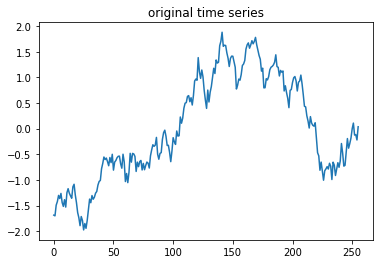

In [7]:
(data,coeff)=time_series_reduction(df[0],3)
#fig, ax= plt.subplots()
plt.plot(df[0],)
plt.title("original time series")
plt.show()



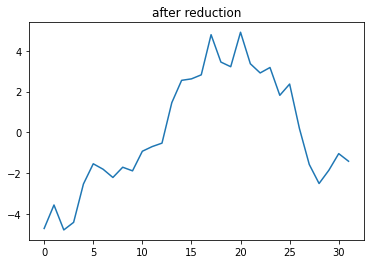

In [8]:
plt.title("after reduction")
plt.plot(data)
plt.show()



In [0]:
def reconstruction(data_reduite, coeff):
  """
  Cette fonction permet la reconstruction des donnees 
  sans modification de vecteurs de coefficient obtenu lors de le la reduction
  """
  for i in range(len(coeff),0,-1):
    #print("i ===={}".format(i))
    
    coefficient = numpy.array([])
    coefficient = numpy.append(coefficient, coeff[i-1])
    print(len(data_reduite))
    print(len(coefficient))
    
    data_reduite = pywt.idwt(data_reduite, coefficient,'sym5',mode="per")
    data_reconstruite=data_reduite
  return data_reconstruite


In [0]:
def array_absolute_value(coeff):
  """
  Cette fonction retourne un tableau en valeur absolu
  """
  coefficient = np.array([])
  for i in range(0,len(coeff)):
    coefficient = np.append(coefficient, abs(coeff[i]))

  return   coefficient


In [0]:

def reduction_coefficient(coeff):
  """
  Cette fonction construit et retourne un vecteur contenant les coefficients reduit a la taille finale des donnes
  et un vecteur contenant les indices des coefficient sauvegardés
  """
  coefficient_reduit=[]
  indice_coefficient=[]
  k=0
  for dimension in range(0,len(coeff)):
    #le tableau en valeur absolu
    x = array_absolute_value(coeff[dimension])
    
    #tri du tableau pour garder les plus grands coefficients
    x.sort()

    
    l=2**(len(coeff) + 1 - dimension)

    if len(coeff) == 5 and (dimension == 3 or dimension==4):
      l=l*2

    if  l > len(coeff[dimension]):
      l=2**(len(coeff) - dimension -1)

    if (len(coeff) == 2) or (len(coeff) == 3  and dimension == 0):
      y=x[len(x)-(len(x)//l)*2]
    else:
      y=x[len(x)-len(x)//l]

    coeff_reconstruction = np.array([],np.float32)
    indice = np.array([],np.float32)

    for i in range(0,len(x)):
      if abs(coeff[dimension][i]) >= y and k < len(coeff[len(coeff)-1]):
        coeff_reconstruction = np.append(coeff_reconstruction, np.array(coeff[dimension][i],np.float32))
        indice = np.append(indice,np.array(i,np.float32))
        k=k+1
    coefficient_reduit.append(coeff_reconstruction)
    indice_coefficient.append(indice)
    #for i in range(0,coefficient_reduit):
    #  coefficient_reduit=


  return(coefficient_reduit,indice_coefficient)


In [0]:
def reconstruction_coefficient(coefficient_reduit , indice_coefficient):
  """
  Cette fonction recontruit le tableau de coefficient suivant les indices des coefficients
  """
  coefficient_reconstruit = []
  for dimension in range(0,len(coefficient_reduit)):
    coeff_reconstruit = numpy.array([])
    j = 0
    c = [ 128, 64 , 32, 16, 8, 4, 2 ]
    for i in range(0,c[dimension]):
      if j < len(indice_coefficient[dimension]) and i == indice_coefficient[dimension][j]:
        coeff_reconstruit = numpy.append(coeff_reconstruit, coefficient_reduit[dimension][j])
        j+=1
      else:
        coeff_reconstruit = numpy.append(coeff_reconstruit, 0.0)
    coefficient_reconstruit.append(coeff_reconstruit)

  return coefficient_reconstruit
      
  

In [0]:
#cette fonction va permetre de merger les indice avec les coefficient histoire de gagner de l'espace
#en effet les coefficient sont entre 1 -1 on va rajouter l indice au coefficient 
#exemple coef 0.856 indice 15 va devenir 150.856 

def merge_coeff_indice(indice,coeff):
  merged_indice_coeff=[]
  for i in range(0,len(coeff)):
    val = indice[i]*10+abs(coeff[i])
    if coeff[i] < 0:
      val*=-1
    merged_indice_coeff.append(np.float32(val))
    
  return merged_indice_coeff

In [0]:
def reduction_data_set(originale_data_set,vers,taille):
  """
  dans cette methode on va retourner le dataset reduit (traiter tout le data set)
  vers pour savoir ql version de reduction 
  VERS 3,4,5 => 128,64,32
  """ 
  df_reduced=pd.DataFrame()
  coef=pd.DataFrame()
  coef_reduced=pd.DataFrame()
  

  for i in range(0,taille):
    if i % 5000 == 0:
      print("{} queries left".format(taille - i))
    (data,coeff)=time_series_reduction(originale_data_set[i],vers)
    df_reduced[i]=data
    coef[i]=coeff
    
  for i in range(0,taille):
    if i % 5000 == 0:
      print("{} coeffs left".format(taille - i))
    (c1,indice1) =reduction_coefficient(coef[i])
    indice_coeff_merged1=merge_coeff_indice(np.concatenate(indice1,axis=None),np.concatenate(c1,axis=None))
    coef_reduced[i] =np.array(indice_coeff_merged1,np.float32)


  return df_reduced,coef_reduced

# **SYNTHETIC REDUCTION 50K**

In [0]:
filename="/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/synthetic_size50k_len256_znorm.bin"
time_series = np.fromfile(filename, dtype=np.float32).reshape(-1, 256)
t=time_series.transpose()
df= pd.DataFrame(t)

In [0]:
df_reduced_128,coef_reduced_128=reduction_data_set(df,3,50000)
df_reduced_64,coef_reduced_64=reduction_data_set(df,4,50000)
df_reduced_32,coef_reduced_32=reduction_data_set(df,5,50000)

In [0]:
save_time_series(df_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_128.bin")
save_time_series(df_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_64.bin")
save_time_series(df_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/red_synthetic_50k_32.bin")
save_time_series(coef_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/coef_synthetic_50k_128.bin")
save_time_series(coef_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/coef_synthetic_50k_64.bin")
save_time_series(coef_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/coef_synthetic_50k_32.bin")

# **SIESMIC REDUCTION 50k**

In [0]:
filename="/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/seismic_size50k_len256_znorm.bin"
time_series = np.fromfile(filename, dtype=np.float32).reshape(-1, 256)
t=time_series.transpose()
df_seismic= pd.DataFrame(t)

In [0]:
df_seismic_reduced_128,coef_seismic_reduced_128=reduction_data_set(df_seismic,3,50000)
df_seismic_reduced_64,coef_seismic_reduced_64=reduction_data_set(df_seismic,4,50000)
df_seismic_reduced_32,coef_seismic_reduced_32=reduction_data_set(df_seismic,5,50000)

In [0]:
save_time_series(df_seismic_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_128.bin")
save_time_series(df_seismic_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_64.bin")
save_time_series(df_seismic_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/red_seismic_50k_32.bin")
save_time_series(coef_seismic_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/coef_seismic_50k_128.bin")
save_time_series(coef_seismic_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/coef_seismic_50k_64.bin")
save_time_series(coef_seismic_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic/coef_seismic_50k_32.bin")

# TESTS

In [0]:
df_reduced_128=pd.DataFrame()
df_reduced_64=pd.DataFrame()
df_reduced_32=pd.DataFrame()

coef_128=pd.DataFrame()
coef_64=pd.DataFrame()
coef_32=pd.DataFrame()


coef_reduced_128=pd.DataFrame()
coef_reduced_64=pd.DataFrame()
coef_reduced_32=pd.DataFrame()


for i in range(0,50000):
  #128b
  (data,coeff)=time_series_reduction(df[i],3)
  df_reduced_128[i]=data
  coef_128[i]=coeff
  #64bits
  (data2,coeff2)=time_series_reduction(df[i],4)
  df_reduced_64[i]=data2
  coef_64[i]=coeff2
  #32bits
  (data3,coeff3)=time_series_reduction(df[i],5)
  df_reduced_32[i]=data3
  coef_32[i]=coeff3
  
save_time_series(df_reduced_128,"red_synth_50k_128.bin")
save_time_series(df_reduced_64,"red_synth_50k_64.bin")
save_time_series(df_reduced_32,"red_synth_50k_32.bin")

for i in range(0,50000):
  #128b
  (c1,indice1) =reduction_coefficient(coef_128[i])
  indice_coeff_merged1=merge_coeff_indice(np.concatenate(indice1,axis=None),np.concatenate(c1,axis=None))
  coef_reduced_128[i]=np.array(indice_coeff_merged1,np.float32)
  #64b
  (c2,indice2) =reduction_coefficient(coef_64[i])
  indice_coeff_merged2=merge_coeff_indice(np.concatenate(indice2,axis=None),np.concatenate(c2,axis=None))
  coef_reduced_64[i]=np.array(indice_coeff_merged2,np.float32)
   #32b
  (c3,indice3) =reduction_coefficient(coef_32[i])
  indice_coeff_merged3=merge_coeff_indice(np.concatenate(indice3,axis=None),np.concatenate(c3,axis=None))
  coef_reduced_32[i]=np.array(indice_coeff_merged3,np.float32)
  
 

In [0]:
print(df.memory_usage())
print(df_reduced_128.memory_usage())
print(df_reduced_64.memory_usage())
print(df_reduced_32.memory_usage())


In [0]:
print(df[0])
print(df_reduced_128[0])
print(df_reduced_64[0])
print(df_reduced_32[0])


In [0]:

print(coef_reduced_128.shape)
print(coef_reduced_128[4999])
save_time_series(coef_reduced_128,"coeff_synth_50k_128.bin")


In [0]:
print(coef_reduced_128[0])
print(df[0])

In [0]:
time_series = np.fromfile("coeff_synth_50k_128.bin",np.float32).reshape(-1,32)
t=time_series.transpose()
df5=pd.DataFrame(t)
print(df5.memory_usage())
print(df5[4999])

In [0]:
print(coef_reduced_64.shape)
print(coef_reduced_64[4999])
save_time_series(coef_reduced_64,"coeff_synth_50k_64.bin")

In [0]:
time_series = np.fromfile("coeff_synth_50k_64.bin",np.float32).reshape(-1, 16)
t=time_series.transpose()
dff=pd.DataFrame(t)
#print(dff.memory_usage())
#len(df[0])
print(dff[4999])

In [0]:
print(dff[5])
print(coef_reduced_64[5])
print(dff.memory_usage())

In [0]:
print(coef_reduced_32.shape)
print(coef_reduced_32[4999])
save_time_series(coef_reduced_32,"coeff_synth_50k_32.bin")

In [0]:
time_series = np.fromfile("coeff_synth_50k_32.bin",np.float32).reshape(-1, 8)
t=time_series.transpose()
dfff=pd.DataFrame(t)
print(dfff[4999])


In [0]:
print(dfff[5])
print(coef_reduced_32[5])

In [0]:
print(dfff.memory_usage())

# **QUERIES**

In [0]:
filename="/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/seismic-query_size100_len256_znorm.bin"
time_series_100 = np.fromfile(filename, dtype=np.float32).reshape(-1, 256)
print(time_series_100.shape)
t100=time_series_100.transpose()
print(t100.shape)
print(len(t100[0]))
df_seismic_100= pd.DataFrame(t100)
print(len(df[0]))
df_seismic100_reduced_128,coef_seismic100_reduced_128=reduction_data_set(df_seismic_100,3,100)
save_time_series(df_seismic100_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_128.bin")

df_seismic100_reduced_64,coef_seismic100_reduced_64=reduction_data_set(df_seismic_100,4,100)
save_time_series(df_seismic100_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_64.bin")

df_seismic100_reduced_32,coef_seismic100_reduced_32=reduction_data_set(df_seismic_100,5,100)
save_time_series(df_seismic100_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_siesmic_query/red_seismic_size100_32.bin")



In [0]:
filename="/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic/synthetic_size50k_len256_znorm.bin"
time_series_100 = np.fromfile(filename, dtype=np.float32).reshape(-1, 256)
print(time_series_100.shape)
t100=time_series_100.transpose()
print(t100.shape)
print(len(t100[0]))
df_seismic_100= pd.DataFrame(t100)
print(len(df[0]))
df_seismic100_reduced_128,coef_seismic100_reduced_128=reduction_data_set(df_seismic_100,3,100)
save_time_series(df_seismic100_reduced_128,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_128.bin")

df_seismic100_reduced_64,coef_seismic100_reduced_64=reduction_data_set(df_seismic_100,4,100)
save_time_series(df_seismic100_reduced_64,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_64.bin")

df_seismic100_reduced_32,coef_seismic100_reduced_32=reduction_data_set(df_seismic_100,5,100)
save_time_series(df_seismic100_reduced_32,"/content/drive/My Drive/Colab Notebooks/data science/reduced_synthetic_query/red_synthetic_size100_32.bin")

